<a href="https://colab.research.google.com/github/mrpep/my-colabs/blob/master/arboles-decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Parte 1 (20 minutos)

i) Definir una función que genere N puntos con M atributos siguiendo una distribución gaussiana.

[Generar datos sintéticos con scikit](https://towardsdatascience.com/https-medium-com-faizanahemad-generating-synthetic-classification-data-using-scikit-1590c1632922)

```def dataset_sintetico_gausianas(medias,covs,n_puntos,etiquetas)```

Si llamamos a esta funcion con: 
```
c1_mean = [0,3]
c2_mean = [3,0]
c3_mean = [2,3]
c4_mean = [1,2]
medias = [c1_mean,c2_mean,c3_mean,c4_mean]
cov = [[0.4,0],[0,1.2]]
covs = [cov,cov,cov,cov]
n_puntos = [100,100,100,100]
etiquetas = ['A','B','B','A']
```

Esto significa que tengo cuatro gaussianas bivariadas con distintas medias, y dos corresponden a la clase 'A', y las otras a 'B'. De cada gaussiana muestreo 100 puntos.
La función debe devolver un dataframe con los 400 puntos como filas, cada dimensión como columna (en este caso 2 porque la gausiana es bivariada), y una columna extra con nombre 'Clase' que indique si el punto pertenece a 'A' o a 'B'.

Tip:
np.random.multivariate_normal permite generar gausianas multivariadas.

ii) Realizar un scatter plot como el mostrado debajo utilizando la función scatterplot de seaborn con el dataframe que devuelve la función al ser llamada con los argumentos dados como ejemplo.

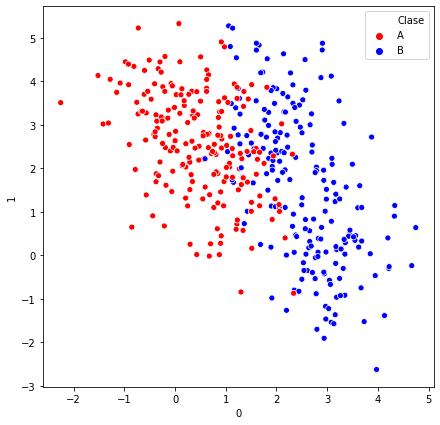


In [0]:
def dataset_sintetico_gausianas(means,covs,points,labels,seed=1234):
  all_dfs = []
  np.random.seed(seed)
  for mean_i,cov_i,points_i,label_i in zip(means,covs,points,labels):
    features_i = np.random.multivariate_normal(mean=mean_i, cov=cov_i,size=points_i)
    dataset_i = pd.DataFrame(features_i)
    dataset_i['Clase'] = label_i
    all_dfs.append(dataset_i)
  
  return pd.concat(all_dfs)


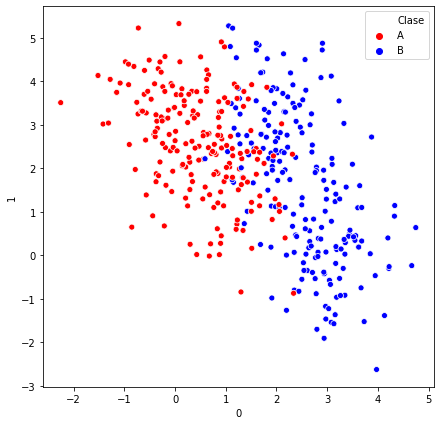

In [0]:
cov = [[0.4,0],[0,1.2]]
c1_mean = [0,3]
c2_mean = [3,0]
c3_mean = [2,3]
c4_mean = [1,2]

dataset = dataset_sintetico_gausianas([c1_mean,c2_mean,c3_mean,c4_mean],[cov,cov,cov,cov],[100,100,100,100],['A','B','B','A'])

plt.figure(figsize=(7,7))
sns.scatterplot(x=0,y=1,hue='Clase',data=dataset,palette={'A':'red','B':'blue'})


# Parte 2 (15 minutos)

Vamos a armar un árbol de decisión desde cero!

![alt text](https://elf11.github.io/images/decisionTree.png "Logo Title Text 1")

Para construir un árbol, debemos encontrar qué atributo dividir, y a partir de qué valor. Lo primero que vamos a hacer es:

i) Definir una función **partir** que toma como argumentos un dataframe, el nombre de un descriptor, y un valor. Lo que devuelve es una lista con 2 dataframes, uno conteniendo aquellas instancias en donde el descriptor es menor al valor, y otro conteniendo aquellas instancias en donde el descriptor es mayor al valor.

Ahora que podemos dividir nuestro dataset en subgrupos, queremos ver qué tan buena es esa división. Para eso tenemos que utilizar alguna medida de cuán puros quedaron los subgrupos. Si al dividir en grupos, en uno quedaron 50 instancias de la clase A y 50 de la B, y en el otro lo mismo, la división será mala. En cambio, si en uno de los grupos quedaron solo las instancias de la clase A y en el otro solo las de la clase B, entonces esa es una buena división.

Una medida posible es la **entropía**:

$H(x) = -\sum_{i=0}^{N}p_x(x_i)log(p_x(x_i))$

En donde $p_x(x_i)$ es la probabilidad de que un dato perteneciente a X (nuestro dataset), pertenezca a la clase i. Para aproximar esta probabilidad, debemos contar la proporción de muestras en el grupo que pertenecen a la clase i.

Otra medida utilizada es la **impureza de Gini**:

$G(x) = \sum_{i=0}^{N}p_x(x_i)(1-p_x(x_i))$


ii) Implementar una función que al darle una lista con los 2 grupos (dataframes) devuelve una de las medidas descritas anteriormente (elegir una).
Tener en cuenta que vamos a obtener una medida de impureza de Gini o de entropia $G_i$ para cada grupo. Estas deberan combinarse mediante una suma pesada por el tamaño $N_i$ de cada particion respecto al tamaño de los datos antes de partir. En este caso en el que dividimos binariamente sería:

$G_1\frac{N_1}{N_1+N_2} + G_2\frac{N_2}{N_1+N_2}$


iii) Armar 2 casos extremos, uno en el que cada grupo contiene una sola clase, y otro en el que los grupos contienen la misma cantidad de muestras para cada clase. Pasarlos a la función implementada en ii) y ver los valores que toma.

In [0]:
def partir(dataset,feature,valor):
  datos_menor = dataset[dataset[feature] < valor]
  datos_mayor = dataset[dataset[feature] >= valor]
  return [datos_menor,datos_mayor]

In [0]:
def impureza_gini(grupos):
  datos_completos = pd.concat(grupos)
  N = len(datos_completos)
  gini = 0
  for grupo in grupos:
    props = grupo['Clase'].value_counts(normalize=True)
    props = props.dropna()
    gini_i = (props*(1-props)).sum()
    gini += gini_i*(len(grupo)/N)
  return gini

def entropia(grupos):
  datos_completos = pd.concat(grupos)
  N = len(datos_completos)
  entropia = 0
  for grupo in grupos:
    props = grupo['Clase'].value_counts(normalize=True)
    props = props.dropna()
    ent_i = -(props*np.log2(props)).sum()
    entropia += ent_i*(len(grupo)/N)
  return entropia

In [0]:
df_a = dataset[dataset['Clase']=='A']
df_b = dataset[dataset['Clase']=='B']

#Peor caso:
g1 = pd.concat([df_a.iloc[:int(len(df_a)/2)],df_b.iloc[:int(len(df_b)/2)]])
g2 = pd.concat([df_a.iloc[int(len(df_a)/2):],df_b.iloc[int(len(df_b)/2):]])

print('Peor caso - Gini: {}'.format(impureza_gini([g1,g2])))
print('Peor caso - Entropía: {}'.format(entropia([g1,g2])))

g1 = df_a
g2 = df_b

print('Mejor caso - Gini: {}'.format(impureza_gini([g1,g2])))
print('Mejor caso - Entropía: {}'.format(entropia([g1,g2])))

Peor caso - Gini: 0.5
Peor caso - Entropía: 1.0
Mejor caso - Gini: 0.0
Mejor caso - Entropía: 0.0


# Parte 3 (15 minutos)

Vamos muy bien! Ya tenemos una función que divide nuestros datos en grupos, y tenemos otra función que nos dice cuán buena es la división. Ahora lo que tenemos que encontrar es cuál es la mejor división posible:

i) Implementar una función **buscar_mejor_particion** que tome como argumentos: un dataframe con los datos para particionar, y una lista con el nombre de los descriptores en los que se hará la búsqueda. Deberá devolver un diccionario que represente a la mejor partición. Deberá contener las siguientes claves:

* 'feature': Nombre del descriptor que uso para partir los datos.
* 'valor': Valor a partir del cual los partió.
* 'costo': Impureza de Gini o Entropia.
* 'l' y 'r': Dataframes con las particiones encontradas.

ii) Pasar el dataset sintético a la función definida en i). Cuál es la decisión tomada? Tiene sentido?

In [0]:
def buscar_mejor_particion(datos,features):
  #Partimos de un valor de Gini inicial:
  minimo_gini = 1
  for feature in features: #Recorro cada feature
    for idx, dato in datos.iterrows(): #Recorro cada dato
      valor = dato[feature] #Para cada dato veo cuanto vale en esa feature
      grupos = partir(datos,feature,valor) #Hago una particion usando esa feature con ese valor
      gini = impureza_gini(grupos) #Calculo gini de la particion (o entropia)
      if gini<minimo_gini: #Si es menor que el que antes era minimo entonces esta es mi nueva mejor particion y mi nuevo mejor gini.
        minimo_gini = gini
        mejor_particion = {'feature': feature, 'valor': dato[feature], 'gini': minimo_gini, 'l': grupos[0], 'r': grupos[1]}
  #Una vez que probe todas las combinaciones de features y valores, devuelvo la particion que me quedo con el menor Gini
  return mejor_particion

In [0]:
#Veamos la decisión que toma
mejor = buscar_mejor_particion(dataset,[0,1])
print('{} < {}'.format(mejor['feature'],mejor['valor']))

0 < 1.685366614143872


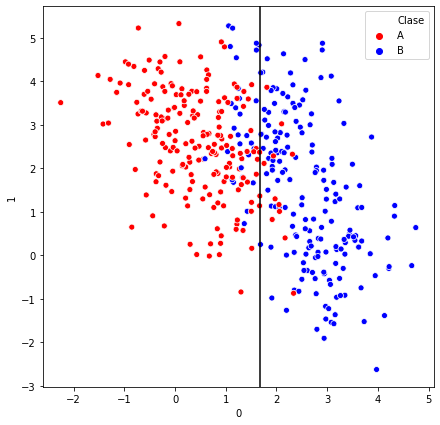

In [0]:
#Si graficamos la decisión, se puede ver que tiene mucho sentido, ya que logra separar muy bien las dos clases:
plt.figure(figsize=(7,7))
sns.scatterplot(x=0,y=1,hue='Clase',data=dataset,palette={'A':'red','B':'blue'})
plt.axvline(x=mejor['valor'],c='k')

# Parte 4 - All together (30 minutos)

Ya casi estamos! Ahora necesitamos seguir tomando decisiones recursivamente. En la Parte 3, logramos implementar el primer nivel del árbol. En esta parte lo que haremos es agregar niveles de forma recursiva hasta que cierto criterio se cumpla. Este criterio puede ser:

* Se alcanza cierta profundidad máxima del árbol.
* Se alcanza un mínimo número de instancias a partir.
* Se alcanza una impureza mínima.

O se puede dejar corriendo hasta que todos los nodos sean puros, aunque eso probablemente lleve a **overfitting**.

i) Implementar una función que tome como argumentos: un dataframe con datos, una lista con los atributos, máxima profundidad y mínimo número de instancias por hoja. Esta función devolverá un árbol de decisión en forma de diccionario (similar al diccionario que devuelve la función buscar_mejor_particion, pero con 'l' y 'r' siendo nuevos diccionarios.

ii) Implementar una función que tome el árbol entrenado en i) y prediga en un nuevo set de datos la clase

iii) Visualizar la frontera de decisión de un árbol sencillo y de uno más complejo

In [0]:
def division_recursiva(datos,features,profundidad_actual,maxima_profundidad,min_inst_hoja):
  #Agarro las dos particiones (<valor y >valor)
  l = datos['l']
  r = datos['r']

  if isinstance(l,pd.core.frame.DataFrame): #Me fijo si lo que llega efectivamente son datos. Si ya se llego a la hoja, sera un string con la clase correspondiente.
    clases_l = l['Clase'].value_counts()
    if (len(clases_l) > 1) & (profundidad_actual<maxima_profundidad) & (clases_l.sum()>min_inst_hoja): #Chequeo que haya mas de una clase en la particion, la profundidad sea menor a la maxima, y la particion tenga un tamaño suficiente.
      #Si todavia no cumple ningun criterio para detener el crecimiento, entonces divide los datos de nuevo buscando la mejor particion:
      l_part = buscar_mejor_particion(l,features) 
      datos['l'] = division_recursiva(l_part,features,profundidad_actual+1,maxima_profundidad,min_inst_hoja) #Esa particion la vuelve a mandar a esta funcion para seguir partiendola.
    else:
      #Si se cumple algun criterio para detener el crecimiento del arbol, entonces queda una hoja con el nombre de la clase mayoritaria:
      datos['l'] = clases_l.idxmax()

  # Se hace todo lo mismo con la particion (> valor)
  if isinstance(r,pd.core.frame.DataFrame):
    clases_r = r['Clase'].value_counts()
    if (len(clases_r) > 1) & (profundidad_actual<maxima_profundidad) & (clases_r.sum()>min_inst_hoja):
      r_part = buscar_mejor_particion(r,features)  
      datos['r'] = division_recursiva(r_part,features,profundidad_actual+1,maxima_profundidad,min_inst_hoja)
    else:
      datos['r'] = clases_r.idxmax()

  return datos

In [0]:
def entrenar_arbol(dataset,features,maxima_profundidad,min_inst_hoja):
  #Armo el primer nivel del arbol y lo paso a la función recursiva para que siga creciendo el árbol.
  nivel_1 = buscar_mejor_particion(dataset,features)
  arbol = division_recursiva(nivel_1,features,1,maxima_profundidad,min_inst_hoja)

  return arbol

Voy a entrenar 2 árboles: 

1. Profundidad 3 y tamaño minimo de hoja 5. 
2. Profundidad 50 y puede tener hojas hasta de una sola instancia.


In [0]:
arbol_entrenado_1 = entrenar_arbol(dataset,[0,1],3,5)
arbol_entrenado_2 = entrenar_arbol(dataset,[0,1],50,1)

Podemos ver el árbol chico (1), qué decisiones o reglas utilizó:

In [0]:
def print_tree(tree,sep=''):
  print('{} {} < {:.2f}'.format(sep,tree['feature'],tree['valor']))
  print('{} SI'.format(sep))
  if isinstance(tree['l'],str):
    print('{} {}'.format(sep+'-',tree['l']))
  else:
    print_tree(tree['l'],sep=sep+'-')

  print('{} NO'.format(sep))
  if isinstance(tree['r'],str):
    print('{} {}'.format(sep+'-',tree['r']))
  else:
    print_tree(tree['r'],sep=sep+'-')

print_tree(arbol_entrenado_1)

 0 < 1.69
 SI
- 0 < 1.04
- SI
-- 0 < 0.59
-- SI
--- A
-- NO
--- A
- NO
-- 1 < 4.54
-- SI
--- A
-- NO
--- B
 NO
- 0 < 2.35
- SI
-- 1 < 2.35
-- SI
--- B
-- NO
--- B
- NO
-- B


Además, una vez que llegan nuevos datos, quiero poder clasificarlos. Entonces armamos una función predecir. Los árboles ya entrenados tienen esta pinta:

In [0]:
arbol_entrenado_1

{'feature': 0,
 'gini': 0.1773868333501361,
 'l': {'feature': 0,
  'gini': 0.1586411462947732,
  'l': {'feature': 0,
   'gini': 0.012950699043414286,
   'l': 'A',
   'r': 'A',
   'valor': 0.5920795956550793},
  'r': {'feature': 1,
   'gini': 0.40746268656716417,
   'l': 'A',
   'r': 'B',
   'valor': 4.540388782853083},
  'valor': 1.0372891185386166},
 'r': {'feature': 0,
  'gini': 0.1010332950631458,
  'l': {'feature': 1,
   'gini': 0.24704434815171455,
   'l': 'B',
   'r': 'B',
   'valor': 2.3500106356628647},
  'r': 'B',
  'valor': 2.350142028222053},
 'valor': 1.685366614143872}

Es decir, son diccionarios anidados. El diccionario que engloba a todos es el primer nivel del árbol, y se ramifica en 2: l y r, que también son diccionarios con claves 'l' y 'r'. Cuanto más niveles tenga el árbol, más anidados los diccionarios.

In [0]:
def predecir(arbol,datos):
  #Miro en el primer nivel cual es el feature y valor de la regla
  feat = arbol['feature']
  val = arbol['valor']
  
  #Ahora me fijo mis datos si feature es menor o mayor al valor de la regla, y en base a eso me fijo si entro al nodo de la izquierda o la derecha:
  if datos[feat] < val:
    #Miro si llegue a una hoja o si todavia tengo que seguir recorriendo el arbol.
    if isinstance(arbol['l'],str):
      clase = arbol['l']
    else:
      #Si tengo que seguir, vuelvo a llamar a esta función mandandole el subarbol correspondiente.
      clase = predecir(arbol['l'],datos)
  else:
    if isinstance(arbol['r'],str):
      clase = arbol['r']
    else:
      clase = predecir(arbol['r'],datos)
  return clase

Para ver qué función aprende el árbol de decisión, vamos a generar una grilla con muchos puntos y ver para cada uno qué predice el árbol de decisión.

In [0]:
#Armado de la grilla:
grid = np.meshgrid(np.arange(-3,6,0.1),np.arange(-3,6,0.1))
x_vals = grid[0].reshape(-1,1)
y_vals = grid[1].reshape(-1,1)

#Armo un dataframe datos_frontera con todos los puntos de la grilla.
datos_frontera = pd.DataFrame(np.concatenate([x_vals,y_vals],axis=1))
#Llamo a predecir con cada uno de los datos en el dataframe. Lo hago para los árboles 1 y 2 que habíamos entrenado.
datos_frontera['Clase_Arbol1'] = datos_frontera.apply(lambda x: predecir(arbol_entrenado_1,x),axis=1)
datos_frontera['Clase_Arbol2'] = datos_frontera.apply(lambda x: predecir(arbol_entrenado_2,x),axis=1)

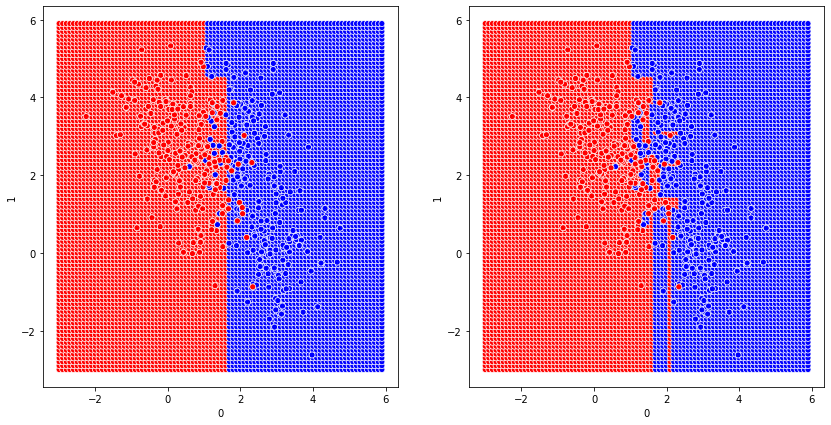

In [0]:
#Grafico todas las predicciones
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
sns.scatterplot(x=0,y=1,hue='Clase_Arbol1',data=datos_frontera,palette={'A':'red','B':'blue'},ax=ax[0])
sns.scatterplot(x=0,y=1,hue='Clase',data=dataset,palette={'A':'red','B':'blue'},ax=ax[0])
ax[0].get_legend().remove()
sns.scatterplot(x=0,y=1,hue='Clase_Arbol2',data=datos_frontera,palette={'A':'red','B':'blue'},ax=ax[1])
sns.scatterplot(x=0,y=1,hue='Clase',data=dataset,palette={'A':'red','B':'blue'},ax=ax[1])
ax[1].get_legend().remove()

Entonces, el gráfico de la izquierda, muestra las predicciones del árbol 1, el cual tiene poca profundidad. El de la derecha muestra las predicciones del árbol 2 que es mucho más profundo. Se puede ver que la frontera de decisión (el límite o borde en el que pasa de clasificar A a clasificar B, o de pintar rojo a azul), es mucho más sencilla en el árbol 1. El árbol 2, tiende a aprender reglas específicas para abarcar casos particulares, que en realidad eran ruido en los datos y van a hacer que no pueda generalizar bien. En otras palabras, el árbol 2 está sobreajustando los datos, casi que memorizandolos para poder clasificar todo bien.

###Cosas a tener en cuenta:

* Las fronteras de decisión son ortogonales (solo puede dividir con rectas a 90° entre si.
* Un árbol lo suficientemente profundo podría aproximar cualquier función matemática (de las normalitas)
* Modelo más complejo != Modelo que mejor generaliza
* Trabajamos en 2D para poder visualizar las cosas, pero en la práctica, el número de dimensiones, que equivale al número de atributos usados, es mucho mayor a lo que podemos observar.

![alt text](https://pbs.twimg.com/media/Dtq79-1X4AA7lJW.jpg)

Generemos otro dataset que siga la misma distribución y veamos cuál árbol da mejor:

In [0]:
dataset_test = dataset_sintetico_gausianas([c1_mean,c2_mean,c3_mean,c4_mean],[cov,cov,cov,cov],[1000,1000,1000,1000],['A','B','B','A'],seed=2345)

pred_arbol1 = dataset_test.apply(lambda x: predecir(arbol_entrenado_1,x),axis=1).values
pred_arbol2 = dataset_test.apply(lambda x: predecir(arbol_entrenado_2,x),axis=1).values

clases_verdaderas = dataset_test['Clase'].values

In [0]:
from sklearn.metrics import accuracy_score

print('Acc Arbol Sencillo: {}'.format(accuracy_score(clases_verdaderas,pred_arbol1)))
print('Acc Arbol Complejo: {}'.format(accuracy_score(clases_verdaderas,pred_arbol2)))

Acc Arbol Sencillo: 0.89275
Acc Arbol Complejo: 0.86475


El árbol más sencillo (1), cuando le damos datos con los que no fue entrenado, es capaz de generalizar mejor, logrando mayor accuracy que el árbol complejo (2).

# La forma fácil

Ahora que ya entendemos a fondo cómo funcionan los árboles de decisión, y hasta los programamos nosotros, podemos relajarnos y que nuestra vida sea más sencilla usando [Scikit-Learn](https://scikit-learn.org/stable/), que permite utilizar de forma sencilla un montón de algorítmos de Machine Learning, y además contiene una documentación muy detallada y comprensiva, la cual es un muy completo recurso para aprender algorítmos de Machine Learning.

Scikit-Learn trae algunos datasets de juguetes para probar algoritmos de ML:

In [0]:
from sklearn.datasets import load_breast_cancer

data_breast = load_breast_cancer()

Casi todo en scikit-learn se utiliza de la misma manera:
1.  Se instancia un modelo, pasándole sus parámetros.
2.  Se ajusta/entrena el modelo mediante el método fit, el cual recibe los datos de entrada y el target
3.  Se predice sobre nuevos datos utilizando el método predict
4.  Se evalua la performance utilizando metricas en el modulo sklearn.metrics



# Dividir en entrenamiento y validación 

In [0]:
#Con sklearn podemos dividir nuestros datos en conjuntos de entrenamiento, validación y prueba.

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

data=data_breast
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=0.3, random_state=42)


#Ajustar el árbol

In [0]:
arbol_sklearn = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=1, ccp_alpha=0)
arbol_sklearn.fit(X_train,y_train)
y_pred_test = arbol_sklearn.predict(X_test)
y_pred_train = arbol_sklearn.predict(X_train)

print('Train acc: {}'.format(accuracy_score(y_train,y_pred_train)))
print('Test acc: {}'.format(accuracy_score(y_test,y_pred_test)))

Train acc: 0.992462311557789
Test acc: 0.9590643274853801


#Predicción del y_test y matriz de confusión

In [0]:
predictions=arbol_sklearn.predict(X_test)

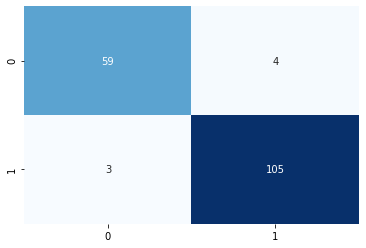

In [0]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cm = confusion_matrix( y_test , predictions)
sns.heatmap(cm,annot=True,fmt='g',cmap='Blues',cbar=False)

#Graficar el árbol

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


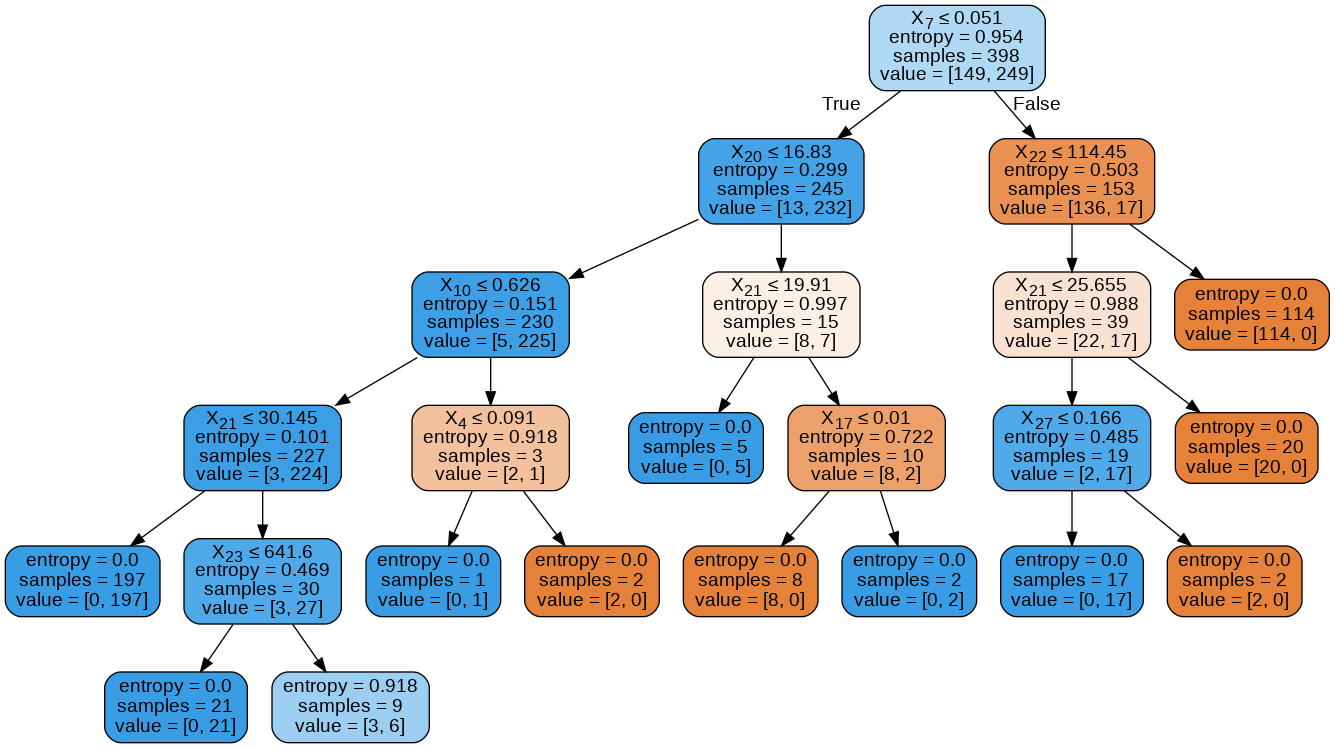

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol_sklearn, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#Podar el árbol



In [0]:

arbol_sklearn = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=1, ccp_alpha=0.05)
arbol_sklearn.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.05, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

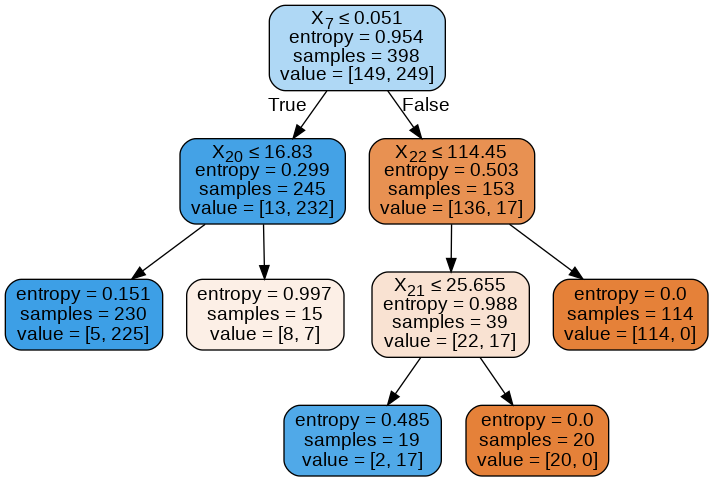

In [0]:
dot_data = StringIO()
export_graphviz(arbol_sklearn, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#Imputar valores nulos

In [0]:
from sklearn import preprocessing
import numpy as np
from sklearn.impute import SimpleImputer

X_train[0,0] = np.nan

print('Antes de imputar nan: {}'.format(X_train[0,0]))
imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
transformed_values = imputer.fit_transform(X_train)
print('Después de imputar nan: {}'.format(transformed_values[0,0]))

Antes de imputar nan: nan
Después de imputar nan: 11.06


# Codificar valores categóricos

Muchas veces tenemos cadenas como nombres de clases, y nuestros modelos de machine learning necesitan recibir números. Podemos utilizar LabelEncoder y hacer esto automáticamente con sklearn

In [0]:
labels = ['Piano','Guitarra','Guitarra','Bateria','Bateria','Piano','Bajo']
le = preprocessing.LabelEncoder()
le.fit_transform(labels)

array([3, 2, 2, 1, 1, 3, 0])

En este caso podemos ver que asignó el 3 a Piano, el 2 a Guitarra, el 1 a Batería y el 0 a Bajo. Pareciera que el criterio fue ordenarlos alfabeticamente.